# Bokeh Brown Bag

## Load Dataset

In [3]:
import wget

# Download dataset from public source
url = 'https://data.austintexas.gov/api/views/3syk-w9eu/rows.csv?accessType=DOWNLOAD'
filename = wget.download(url)
print(filename)

Issued_Construction_Permits.csv


In [1]:
import pandas as pd

# Load dataset
df = pd.read_csv('Issued_Construction_Permits.csv', low_memory=False)
df.head(2)
print("Number of rows...", df['PermitType'].count())

Number of rows... 1873852


## Preprocess Data

In [2]:
# Get project valuations by year
data = df[(df['CalendarYearIssued'] >= 1980) &
          (df['PermitTypeDesc']=='Building Permit') &
          (df['StatusCurrent'].isin(['Final', 'Active', 'Closed']))
         ] \
    .groupby(['CalendarYearIssued'])['TotalJobValuation'].agg(['sum','mean','max','count']).reset_index().sort_values(by='CalendarYearIssued')

data['TotalInBillions'] = data['sum']/1000000000
data['AverageInBillions'] = data['mean']/1000000000
data['MaxInBillions'] = data['max']/1000000000

## Matplotlib Example

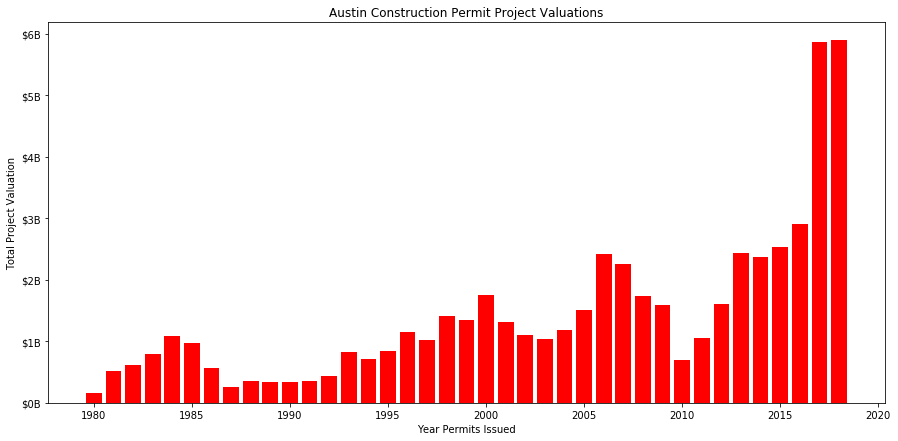

In [5]:
from math import sqrt
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

# Set x and y values
x = data['CalendarYearIssued']
y = data['TotalInBillions']

# Create figure
fig, ax = plt.subplots(figsize=(15,7))

# Create bars
rects1 = ax.bar(x, y, color='r')

# Styling
ax.set_xlabel('Year Permits Issued')
ax.set_ylabel('Total Project Valuation')
ax.set_title('Austin Construction Permit Project Valuations')
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}B'))

plt.show()

## Using Bokeh

In [9]:
from bokeh.io import show, output_notebook
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure

# Creating ColumnDataSource
source = ColumnDataSource(data)

# Create figure
p = figure(plot_height=400
           , plot_width=700
           , title='Austin Construction Permit Project Valuations'
        )

# Creating glyphs
total_renderer = p.line(x='CalendarYearIssued'
        , y='TotalInBillions'
        , color='orange'
        , line_width=4
        , source=source
      )

# Add labels
p.xaxis.axis_label = 'Year Permits Issued'
p.yaxis.axis_label = 'Billion Dollars ($B)'

# Displays chart inline with Jupyter Notebook
output_notebook()

# Render chart visible
show(p)

Loading BokehJS ...

## Styling

In [10]:
def style(p):
    p.plot_height=500
    p.plot_width=800

    p.title.align = 'center'
    p.title.text_font_size = '14pt'

    p.xaxis.axis_label_text_font_size = '12pt'
    p.xaxis.axis_label_text_font_style = 'normal'
    p.xaxis.major_label_text_font_size = '12pt'

    p.yaxis.axis_label_text_font_size = '12pt'
    p.yaxis.axis_label_text_font_style = 'normal'
    p.yaxis.major_label_text_font_size = '12pt'
    
    return p

# Style chart
p = style(p)

show(p)

## Adding More Glyphs

In [11]:
avg_line = p.line(x='CalendarYearIssued'
            , y='MaxInBillions'
            , color="green"
            , line_width=4
            , source=source)

show(p)

## Adding a Legend

In [12]:
total_renderer = p.line(x='CalendarYearIssued'
        , y='TotalInBillions'
        , color='orange'
        , line_width=4
        , source=source
        , legend='Total Valuation All Projects'
      )

avg_renderer = p.line(x='CalendarYearIssued'
            , y='MaxInBillions'
            , color='green'
            , line_width=4
            , source=source
            , legend='Average Valuation per Project'
      )

p.legend.location = "top_left"

show(p)

## Adding a HoverTool

In [13]:
from bokeh.models import HoverTool

# Add a hover functionality for `Total Valuation All Projects` line
deftooltips = [
    ("index", "$index"),
    ("(x,y)", "($x, $y)"),
    ("Calendar Year Issued", "@CalendarYearIssued"),
    ("Total In Billion $", "@TotalInBillions"),
]

total_hover = HoverTool(tooltips=deftooltips, renderers=[total_renderer])
p.add_tools(total_hover)

# Add a hover functionality for `Average Valuation per Project` line
deftooltips = [
    ("index", "$index"),
    ("(x,y)", "($x, $y)"),
    ("Calendar Year Issued", "@CalendarYearIssued"),
    ("Average in $", "@mean{(0,0)}"),
]

avg_hover = HoverTool(tooltips=deftooltips, renderers=[avg_renderer])
p.add_tools(avg_hover)

show(p)

## Configuring Plot Tools

In [14]:
from bokeh.models import PointDrawTool

circles_renderer = p.circle(x='CalendarYearIssued'
              , y='TotalInBillions'
              , fill_color='white'
              , line_color='orange'
              , size=6
              , source=source)

p.add_tools(PointDrawTool(renderers=[circles_renderer]))

show(p)

In [15]:
from bokeh.models import WheelZoomTool, ResetTool

tools = [avg_hover, total_hover, WheelZoomTool(), ResetTool()]
p.tools = tools

p.toolbar_location='above'

show(p)

## Creating Widgets

In [16]:
from bokeh.models import Button, MultiSelect

year_list = data['CalendarYearIssued'].astype(str).unique().tolist()

year_selection = MultiSelect(title='Year'
                             , value=[str(i) for i,j in enumerate(year_list)]
                             , options = [(str(i),j) for i,j in enumerate(year_list)]
                            )

show(year_selection)

In [17]:
def update_run():
    years_to_plot = [x[1] for x in year_selection.options if x[0] in year_selection.value]
    new_data = df[df['CalendarYearIssued'].isin(years_to_plot)]
    new_source = ColumnDataSource(new_data)
    source.data.update(new_source.data)

update_plot = Button(label='Update Plot')
update_plot.on_click(update_run)
show(update_plot)

You are generating standalone HTML/JS output, but trying to use real Python
callbacks (i.e. with on_change or on_event). This combination cannot work.

Only JavaScript callbacks may be used with standalone output. For more
information on JavaScript callbacks with Bokeh, see:

    http://bokeh.pydata.org/en/latest/docs/user_guide/interaction/callbacks.html

Alternatively, to use real Python callbacks, a Bokeh server application may
be used. For more information on building and running Bokeh applications, see:

    http://bokeh.pydata.org/en/latest/docs/user_guide/server.html



In [18]:
def update_selectall():
    year_selection.value = [x[0] for x in year_selection.options]

select_all = Button(label='Select All')
select_all.on_click(update_selectall)

show(select_all)

You are generating standalone HTML/JS output, but trying to use real Python
callbacks (i.e. with on_change or on_event). This combination cannot work.

Only JavaScript callbacks may be used with standalone output. For more
information on JavaScript callbacks with Bokeh, see:

    http://bokeh.pydata.org/en/latest/docs/user_guide/interaction/callbacks.html

Alternatively, to use real Python callbacks, a Bokeh server application may
be used. For more information on building and running Bokeh applications, see:

    http://bokeh.pydata.org/en/latest/docs/user_guide/server.html



In [19]:
from bokeh.layouts import WidgetBox
from bokeh.models import Div

controls = WidgetBox(Div(text='<h1>Widgets Box</h1>'), year_selection, select_all, update_plot, width=150)

show(controls)

You are generating standalone HTML/JS output, but trying to use real Python
callbacks (i.e. with on_change or on_event). This combination cannot work.

Only JavaScript callbacks may be used with standalone output. For more
information on JavaScript callbacks with Bokeh, see:

    http://bokeh.pydata.org/en/latest/docs/user_guide/interaction/callbacks.html

Alternatively, to use real Python callbacks, a Bokeh server application may
be used. For more information on building and running Bokeh applications, see:

    http://bokeh.pydata.org/en/latest/docs/user_guide/server.html



In [20]:
from bokeh.layouts import gridplot

layout = gridplot(children=[[controls, p]])

show(layout)

You are generating standalone HTML/JS output, but trying to use real Python
callbacks (i.e. with on_change or on_event). This combination cannot work.

Only JavaScript callbacks may be used with standalone output. For more
information on JavaScript callbacks with Bokeh, see:

    http://bokeh.pydata.org/en/latest/docs/user_guide/interaction/callbacks.html

Alternatively, to use real Python callbacks, a Bokeh server application may
be used. For more information on building and running Bokeh applications, see:

    http://bokeh.pydata.org/en/latest/docs/user_guide/server.html



## Creating Tabs

In [21]:
# Create figure
p2 = figure(plot_height=400
           , plot_width=700
           , title='Count of Issued Construction Permits'
        )

# Creating glyphs
renderer = p2.vbar(x='CalendarYearIssued'
        , top='count'
        , color='purple'
        , width=0.9
        , source=source
      )

# Add labels
p2.xaxis.axis_label = 'Year Permits Issued'
p2.yaxis.axis_label = 'Number of Permits Issued'

# Style chart
p2 = style(p2)

# Create layout
layout2 = gridplot(children=[[p2]])

# Render chart visible
show(layout2)

In [22]:
from bokeh.models import Panel
from bokeh.models.widgets import Tabs

tab1 = Panel(child=layout, title = 'Valuation')
tab2 = Panel(child=layout2, title = 'Count')
tabs = Tabs(tabs = [tab1, tab2])

show(tabs)

You are generating standalone HTML/JS output, but trying to use real Python
callbacks (i.e. with on_change or on_event). This combination cannot work.

Only JavaScript callbacks may be used with standalone output. For more
information on JavaScript callbacks with Bokeh, see:

    http://bokeh.pydata.org/en/latest/docs/user_guide/interaction/callbacks.html

Alternatively, to use real Python callbacks, a Bokeh server application may
be used. For more information on building and running Bokeh applications, see:

    http://bokeh.pydata.org/en/latest/docs/user_guide/server.html



## Creating HTML output

In [23]:
from bokeh.io import output_file, save

output_file("line_plot_example.html")

# save(layout)
show(layout)

You are generating standalone HTML/JS output, but trying to use real Python
callbacks (i.e. with on_change or on_event). This combination cannot work.

Only JavaScript callbacks may be used with standalone output. For more
information on JavaScript callbacks with Bokeh, see:

    http://bokeh.pydata.org/en/latest/docs/user_guide/interaction/callbacks.html

Alternatively, to use real Python callbacks, a Bokeh server application may
be used. For more information on building and running Bokeh applications, see:

    http://bokeh.pydata.org/en/latest/docs/user_guide/server.html



You are generating standalone HTML/JS output, but trying to use real Python
callbacks (i.e. with on_change or on_event). This combination cannot work.

Only JavaScript callbacks may be used with standalone output. For more
information on JavaScript callbacks with Bokeh, see:

    http://bokeh.pydata.org/en/latest/docs/user_guide/interaction/callbacks.html

Alternatively, to use real Python callbacks, a Bokeh server application may
be used. For more information on building and running Bokeh applications, see:

    http://bokeh.pydata.org/en/latest/docs/user_guide/server.html



## Starting Bokeh Server

Navigate to folder containing `app.py` in Terminal and run `bokeh serve --show app.py`

## Additional Bokeh Server Commands



Additional options `bokeh serve 
                --show app.py 
                --port 1111 
                --address <external-IP>
                --allow-websocket-origin=<destination-IP>:<destination-port>`

## Understanding ColumnDataSource

When you make changes to the source, this will cause changes to occur in the chart.

In [32]:
source.data

{'index': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38]),
 'CalendarYearIssued': array([1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
        1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
        2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
        2013, 2014, 2015, 2016, 2017, 2018]),
 'sum': array([1.66818852e+08, 5.11778373e+08, 6.13543271e+08, 7.94980269e+08,
        1.08342663e+09, 9.79098184e+08, 5.66326909e+08, 2.52307722e+08,
        3.52605856e+08, 3.46206130e+08, 3.45702752e+08, 3.49979623e+08,
        4.29402146e+08, 8.24992439e+08, 7.09024484e+08, 8.41303390e+08,
        1.14946747e+09, 1.02122005e+09, 1.41849214e+09, 1.35086148e+09,
        1.75202141e+09, 1.31277804e+09, 1.10972652e+09, 1.04144176e+09,
        1.17630889e+09, 1.50986862e+09, 2.42673926e+09, 2.25297226e+09,
        

In [47]:
source.data['CalendarYearIssued']

array([1980, 1987, 1990, 1989, 1991, 1988, 1992, 1981, 1986, 1982, 2010,
       1994, 1983, 1993, 1995, 1985, 1997, 2003, 2011, 1984, 2002, 1996,
       2004, 2001, 1999, 1998, 2005, 2009, 2012, 2008, 2000, 2007, 2014,
       2006, 2013, 2015, 2016, 2018, 2017])

## Other Functionality

Create HTML file using command line: `bokeh html app.py`

Create JSON representation using command line: `bokeh json app.py`